In [10]:

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
# from data.synthetic_data_generation.dag_and_data import simulate_linear_scm
# from data.synthetic_data_generation.missingness import apply_missingness

In [13]:
from data.synthetic_data_generation.dag_and_data import (
    random_dag,
    weighted_adj_matrix,
    true_covariance,
    sample_complete_data,
    detect_colliders,
    detect_collider_parents
)

from data.synthetic_data_generation.missingness import (
    create_mar_ind,
    generate_missing_values,
    generate_mcar_reference
)

# Generate DAG and data
G, adj = random_dag(20, seed=1)
W = weighted_adj_matrix(adj, seed=1)
Sigma = true_covariance(W)
X_complete = sample_complete_data(Sigma, 1000, seed=1)

# Missingness setup
colliders = detect_colliders(adj)
collider_parents = detect_collider_parents(adj, colliders)

ms, prt_ms = create_mar_ind(
    colliders,
    collider_parents,
    num_var=20,
    num_extra_e=3,
    num_m=6,
    seed=1
)

X_mar = generate_missing_values(X_complete, ms, prt_ms, seed=1)
X_mcar = generate_mcar_reference(X_complete, X_mar, ms, seed=1)


In [14]:
X_mar.shape


(1000, 20)

In [15]:
import numpy as np

np.isnan(X_mar).sum()


np.int64(2263)

In [16]:
import os
import pandas as pd
import numpy as np

output_dir = os.path.join("data", "synthetic_data")
os.makedirs(output_dir, exist_ok=True)

p = X_complete.shape[1]
var_names = [f"X{i+1}" for i in range(p)]

# Data
pd.DataFrame(X_complete, columns=var_names).to_csv(
    os.path.join(output_dir, "data_complete.csv"), index=False
)
pd.DataFrame(X_mar, columns=var_names).to_csv(
    os.path.join(output_dir, "data_mar.csv"), index=False
)
pd.DataFrame(X_mcar, columns=var_names).to_csv(
    os.path.join(output_dir, "data_mcar.csv"), index=False
)

# DAG
pd.DataFrame(adj, index=var_names, columns=var_names).to_csv(
    os.path.join(output_dir, "dag_ground_truth.csv")
)

# Missingness ground truth
pd.DataFrame({
    "missing_variable": [var_names[i] for i in ms],
    "parent_variable": [var_names[i] for i in prt_ms]
}).to_csv(
    os.path.join(output_dir, "missingness_ground_truth.csv"),
    index=False
)


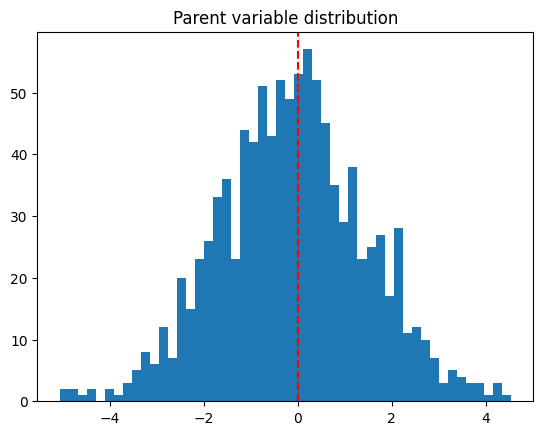

In [17]:
import matplotlib.pyplot as plt

m = ms[0]
plt.hist(X_complete[:, prt_ms[0]], bins=50)
plt.axvline(0, color='red', linestyle='--')
plt.title("Parent variable distribution")
plt.show()


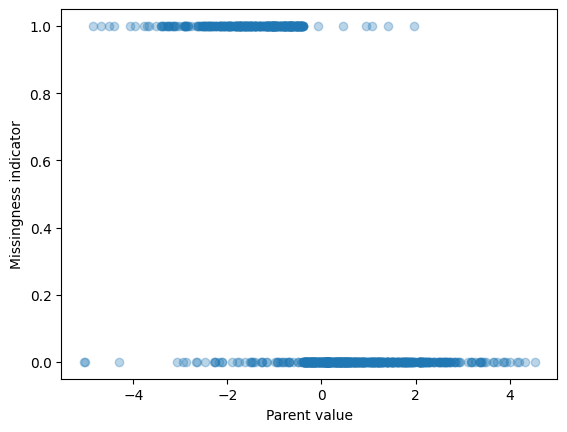

In [18]:
mask = np.isnan(X_mar[:, m])
plt.scatter(
    X_complete[:, prt_ms[0]],
    mask.astype(int),
    alpha=0.3
)
plt.xlabel("Parent value")
plt.ylabel("Missingness indicator")
plt.show()
